# Overview of the `poligrain` package

In [1]:
import sys

sys.path.append('poligrain/src')

In [2]:
import matplotlib.pyplot as plt
import poligrain as plg

## Get OpenMRG example data

<img src="https://essd.copernicus.org/articles/14/5411/2022/essd-14-5411-2022-f02-web.png" alt="drawing" width="300"/>


We download a subset of the OpenMRG dataset which is described in Andersson et al. (2022) here https://doi.org/10.5194/essd-14-5411-2022 and which is available for download at https://doi.org/10.5281/zenodo.6673750

The subset that we use was already processed, in particular the CML data, but with a very basic processing.

In addition, here, we will project the lon-lat coordinates in the fitting UTM zone, so that we can do correct distance calculations.

In [3]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


### Project coordinates to UTM

In [4]:
# Project coordinates for rain gauges
ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, "EPSG:25832"
)
ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauge_smhi.lon, ds_gauge_smhi.lat, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:25832"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:25832"
)

## Intro to data model

In OPENSENSE we agreed on a specific structure and naming convention for storing data in NetCDF, which translates to the respective `xarray.Dataset` objects.

### CML data

In [5]:
ds_cmls

<xarray.Dataset> Size: 1GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates: (12/14)
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    ...            ...
    polarization  (sublink_id, cml_id) <U1 3kB ...
    length        (cml_id) float64 3kB ...
    site_0_x      (cml_id) float64 3kB 6.785e+05 6.776e+05 ... 6.792e+05
    site_0_y      (cml_id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x      (cml_id) float64 3kB 6.783e+05 6.77e+05 ... 6.778e+05
    site_1_y      (cml_id) float64 3kB 6.399e+06 6.402e+06 ... 6.401e+06
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB ...
    rsl           (time, sublink_id, cml_id) float64 403MB ...
    R             (sublink_id, cml_id, time) float64 403MB ...
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

### Gauge data

In [6]:
ds_gauges_municp

<xarray.Dataset> Size: 1MB
Dimensions:          (id: 10, time: 11520)
Coordinates:
  * id               (id) <U6 240B 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 92kB 2015-07-22 ... 2015-07-29T23:...
    lon              (id) float64 80B 11.94 12.04 12.07 ... 11.99 11.97 11.94
    lat              (id) float64 80B 57.65 57.72 57.75 ... 57.71 57.71 57.63
    location         (id) <U16 640B ...
    type             (id) <U14 560B ...
    quantization     (id) float64 80B ...
    x                (id) float64 80B 6.756e+05 6.808e+05 ... 6.757e+05
    y                (id) float64 80B 6.393e+06 6.401e+06 ... 6.392e+06
Data variables:
    rainfall_amount  (id, time) float64 922kB ...

###  Radar data (on cartesian grid)

In [7]:
ds_rad

<xarray.Dataset> Size: 33MB
Dimensions:  (time: 2304, x: 37, y: 48)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2015-07-22 ... 2015-07-29T23:55:00
  * x        (x) float64 296B -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y        (y) float64 384B -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
    lat      (y, x) float64 14kB ...
    lon      (y, x) float64 14kB ...
Data variables:
    crs      int32 4B ...
    R        (time, y, x) float64 33MB ...
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

## Quick look at CML data

Look at RSL, TSL and R of a specific CML

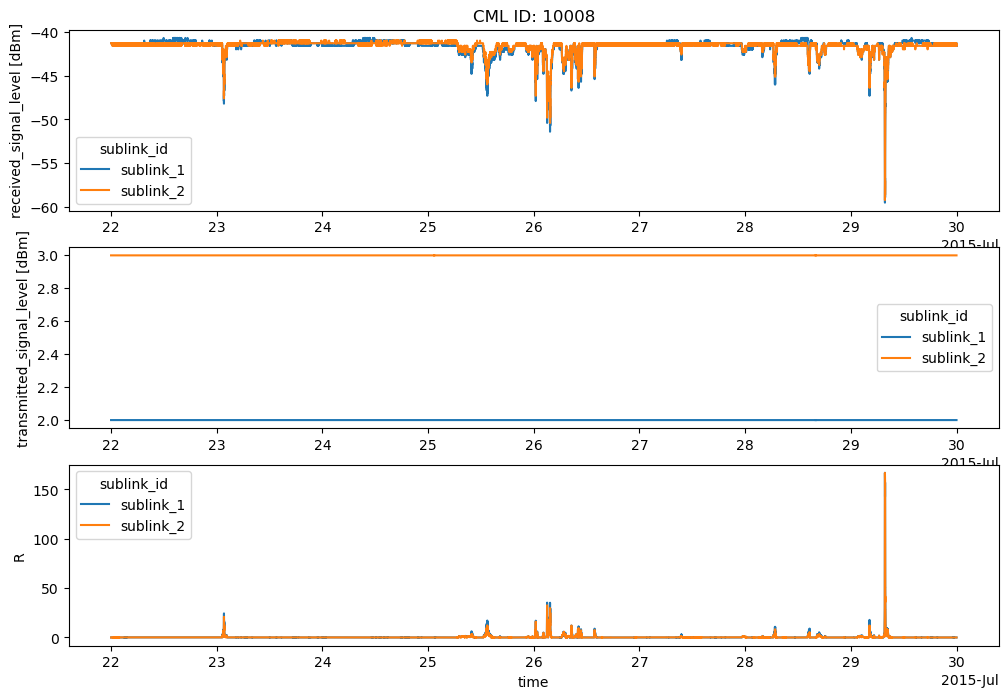

In [8]:
i = 7

fig, axs = plt.subplots(3, 1, figsize=(12, 8))
ds_cmls.isel(cml_id=i).rsl.plot.line(x='time', ax=axs[0])
ds_cmls.isel(cml_id=i).tsl.plot.line(x='time', ax=axs[1])
ds_cmls.isel(cml_id=i).R.plot.line(x='time', ax=axs[2])
[ax.set_title('') for ax in axs]
axs[0].set_title(f'CML ID: {ds_cmls.isel(cml_id=i).cml_id.data}')
axs[0].set_xlabel('')
axs[1].set_xlabel('');

## Excercise 1.1: Look at data from different CMLs

Reuse the plot from above and test with selecting different CMLs

Questions:
- What do you observe?
- Also look closely at the rain rates values.

## Plot hourly rainfall sums for all CMLs

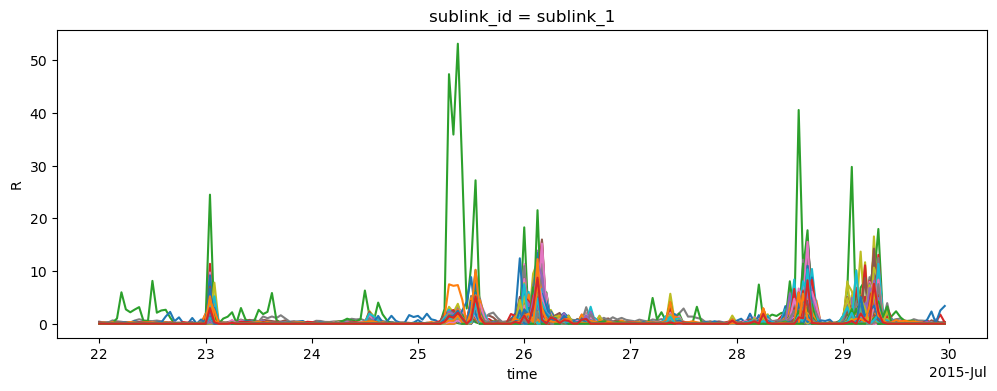

In [9]:
da_R = ds_cmls.R.isel(sublink_id=0)#
da_R.resample(time='1h').mean().plot.line(x='time', add_legend=False, figsize=(12, 4));

## Plot data on a map

CML rain rates for a selected time stamp

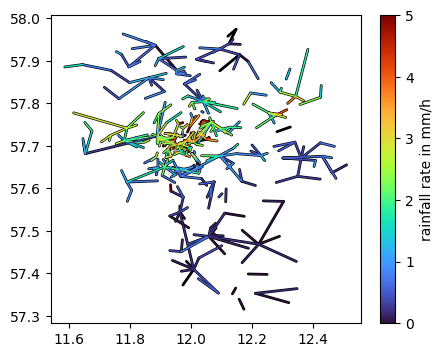

In [10]:
da_R = ds_cmls.R.isel(sublink_id=0).sel(time='2015-07-25 10:00:00')

fig, ax = plt.subplots(figsize=(5, 4))
lines = da_R.plg.plot_cmls(pad_width=1, vmin=0, vmax=5, ax=ax, use_lon_lat=True)
plt.colorbar(lines, label="rainfall rate in mm/h");

Rainfall sums over full period for radar, CMLs and gauges

<Axes: xlabel='lon', ylabel='lat'>

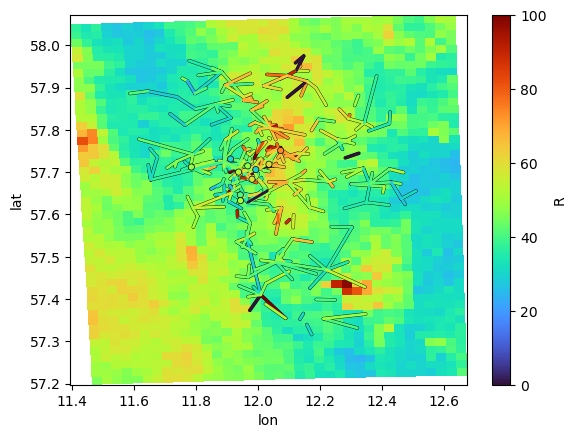

In [11]:
plg.plot_map.plot_plg(
    da_grid=ds_rad.R.resample(time='1h').mean().sum(dim="time"),
    da_gauges=ds_gauges_municp.rainfall_amount.sum(dim="time"),
    use_lon_lat=True,
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim="time"),
    vmin=0,
    vmax=100,
)

## Extract radar along CML paths and compare data

In [12]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad,
    ds_line_data=ds_cmls,
)

In [13]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_rad.R)

In [14]:
radar_along_cml

<xarray.DataArray (time: 2304, cml_id: 364)> Size: 7MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * cml_id      (cml_id) int64 3kB 10001 10002 10003 10004 ... 10362 10363 10364
  * time        (time) datetime64[ns] 18kB 2015-07-22 ... 2015-07-29T23:55:00
    site_0_lat  (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon  (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat  (cml_id) float64 3kB 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    site_1_lon  (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    length      (cml_id) float64 3kB ...
    site_0_x    (cml_id) float64 3kB 6.785e+05 6.776e+05 ... 6.808e+05 6.792e+05
    site_0_y    (cml_id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x    (cml_id) float64 3kB 6.783e+05 6.77e+05 ... 6.772e+05 6.778e+05
    site_1_y    (cml_id) float64 3kB 6.399e+06 6.402e+06 ... 6.391e+06 6.401e+06

Aggregate to hourly rainfall for comparison

In [15]:
radar_along_cml_R_1h = radar_along_cml.resample(time='1h').mean()
cmls_R_1h = ds_cmls.R.isel(sublink_id=0).resample(time='1h').mean()

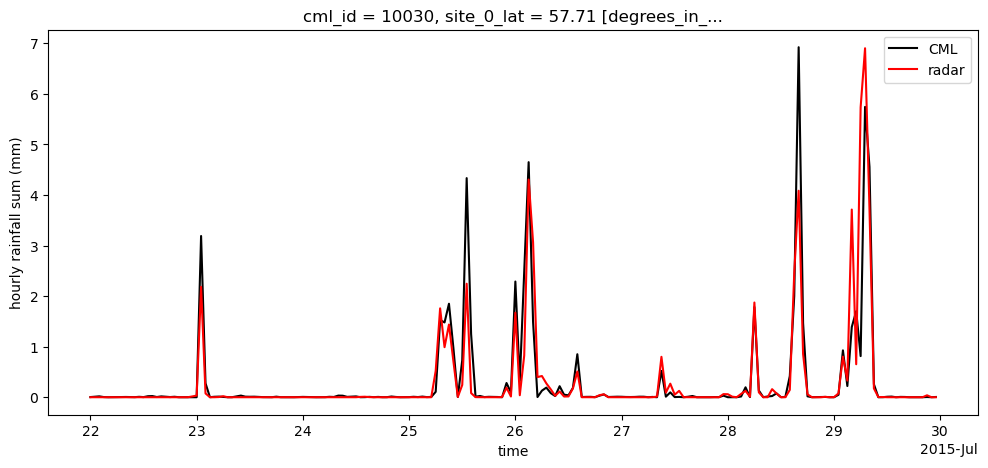

In [16]:
cml_id = 10030

cmls_R_1h.sel(cml_id=cml_id).plot(color='k', figsize=(12, 5), label='CML')
radar_along_cml_R_1h.sel(cml_id=cml_id).plot(color='r', label='radar')
plt.legend()
plt.ylabel('hourly rainfall sum (mm)');

<Axes: >

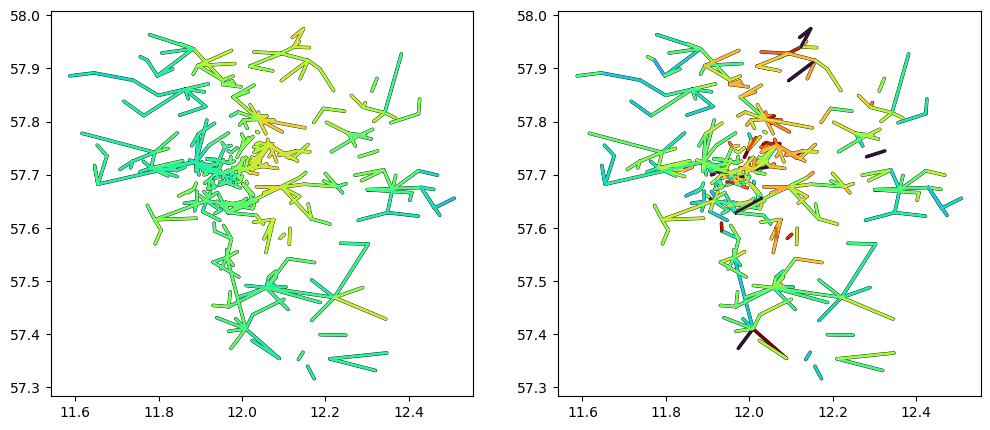

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plg.plot_map.plot_plg(
    da_cmls=radar_along_cml_R_1h.sum(dim='time'), 
    ax=axs[0], 
    vmin=0, 
    vmax=100,
)
plg.plot_map.plot_plg(
    da_cmls=cmls_R_1h.sum(dim='time'), 
    ax=axs[1],
    vmin=0,
    vmax=100,
)

## Excercise 1.2: Analyse difference between radar and CML

- 1.2.1: Do a scatter plot (`plt.scatter`) of the total rainfall sums for both radar and CML data.

- 1.2.2: Identify problematic CMLs and look at their raw TSL and RSL data. Is there any noticeable pattern?

- 1.2.3: Calculate the difference between radar and CML rainfall sums. Plot this difference as a map using `plg.plot_map.plot_plg`

In [18]:
radar_along_cml_R_sum = radar_along_cml_R_1h.sum(dim='time')
cmls_R_sum = cmls_R_1h.sum(dim='time')

(0.0, 70.0)

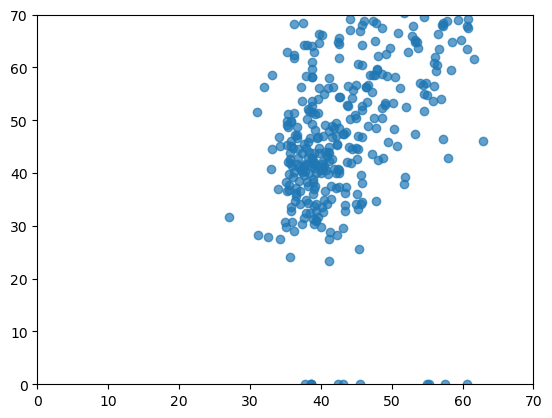

In [19]:
plt.scatter(radar_along_cml_R_sum, cmls_R_sum, alpha=0.7)
plt.xlim([0, 70])
plt.ylim([0, 70])

In [20]:
cml_ids_with_zero_rainfall = cmls_R_sum.cml_id.data[cmls_R_sum == 0]
cml_ids_with_zero_rainfall

array([10034, 10041, 10074, 10134, 10135, 10145, 10269, 10273, 10276,
       10303])

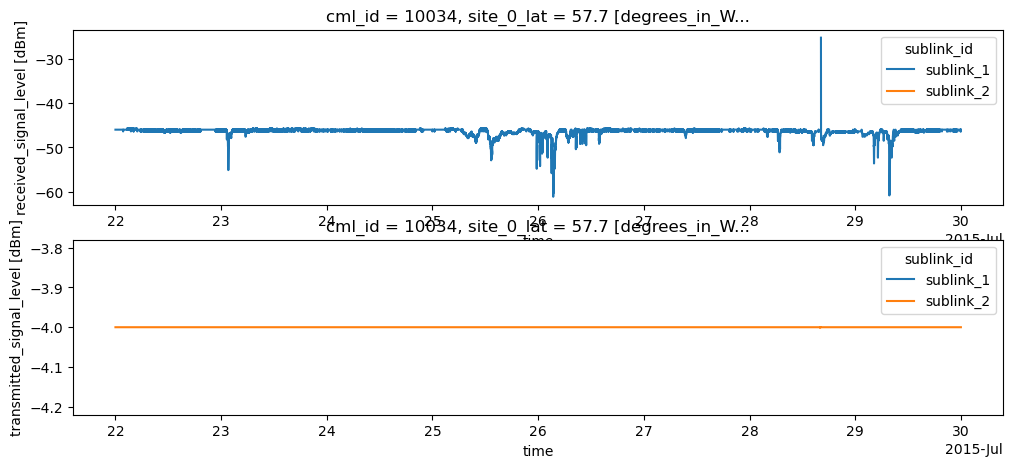

In [21]:
i = 0

fig, axs = plt.subplots(2, 1, figsize=(12, 5))
ds_cmls.sel(cml_id=cml_ids_with_zero_rainfall[i]).rsl.plot.line(x='time', ax=axs[0])
ds_cmls.sel(cml_id=cml_ids_with_zero_rainfall[i]).tsl.plot.line(x='time', ax=axs[1]);

<Axes: >

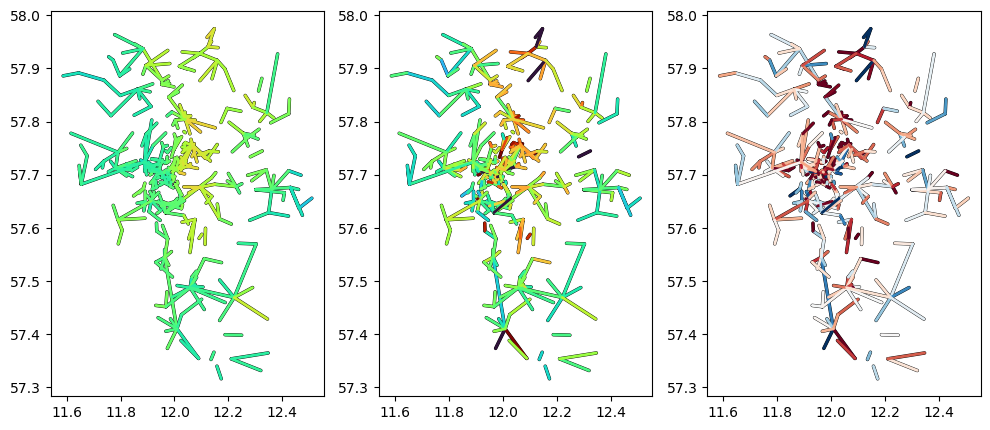

In [22]:
da_diff = radar_along_cml_R_sum - cmls_R_sum

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
plg.plot_map.plot_plg(da_cmls=radar_along_cml_R_sum, ax=axs[0], vmin=0, vmax=100)
plg.plot_map.plot_plg(da_cmls=cmls_R_sum, ax=axs[1], vmin=0, vmax=100)
plg.plot_map.plot_plg(da_cmls=da_diff, ax=axs[2], vmin=-20, vmax=20, cmap='RdBu')

## Find gauges close to CMLs and compare data

In [23]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cmls, ds_gauges_municp, max_distance=max_distance, n_closest=10
)

In [24]:
closest_neigbors

<xarray.Dataset> Size: 61kB
Dimensions:      (cml_id: 364, n_closest: 10)
Coordinates:
  * cml_id       (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
Dimensions without coordinates: n_closest
Data variables:
    distance     (cml_id, n_closest) float64 29kB 287.0 1.739e+03 ... inf inf
    neighbor_id  (cml_id, n_closest) object 29kB 'Drakeg' 'Chalm' ... None None

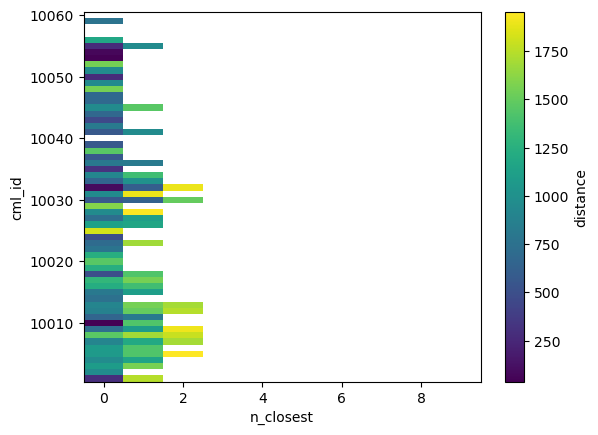

In [25]:
closest_neigbors.isel(cml_id=slice(0, 60)).distance.plot();

<Axes: >

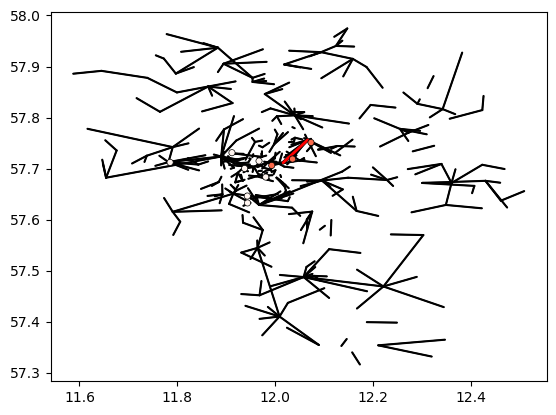

In [26]:
# plot CMLs and gauges on map and highlight those that are closer than 5000m
cml_id = 10030

# hacky way to get bool array with closest gauges set to True
da_gauges_close = (ds_gauges_municp.id == closest_neigbors.neighbor_id.sel(cml_id=cml_id)).max(dim='n_closest')

fig, ax = plt.subplots()
plg.plot_map.plot_lines(ds_cmls, line_color='k', ax=ax)
plg.plot_map.plot_lines(ds_cmls.sel(cml_id=cml_id), line_color='r', line_width=2, ax=ax)
# hacky way to plot the gauges highligting the close ones
plg.plot_map.plot_plg(da_gauges=da_gauges_close, ax=ax, vmin=0, vmax=2, cmap='Reds')


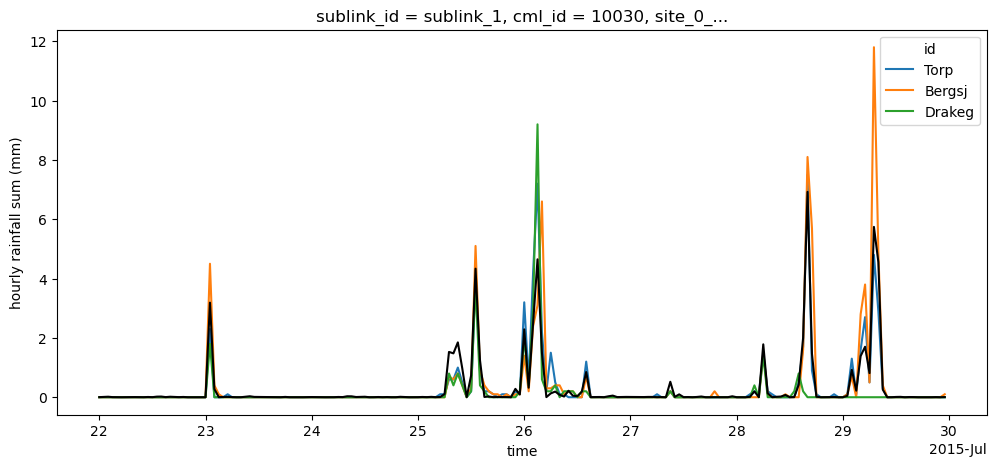

In [27]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
ds_closests_gauges.rainfall_amount.resample(time='1h').sum().plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean().plot(color='k')
plt.ylabel('hourly rainfall sum (mm)');

Let's zoom in and plot the data with the original temporal resolution

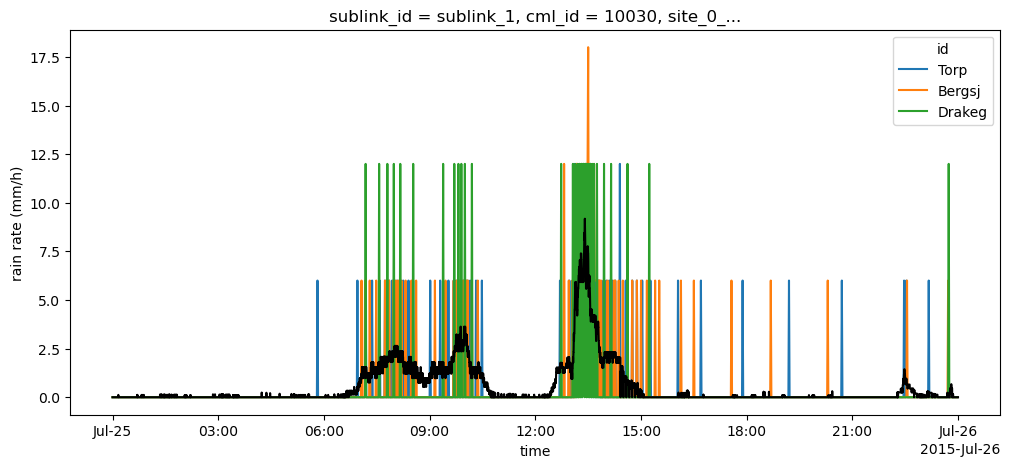

In [28]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
(ds_closests_gauges.sel(time='2015-07-25').rainfall_amount * 60).plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id, time='2015-07-25').R.plot(color='k')
plt.ylabel('rain rate (mm/h)');

If we aggregate the gauge to 5-minute rain rates we some more dynamics in the gauge data.

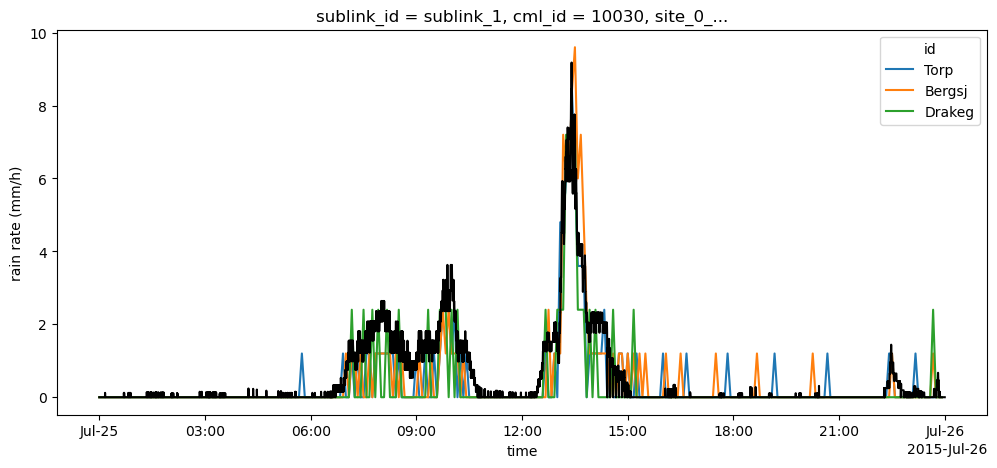

In [29]:
cml_id = 10030
ds_closests_gauges = (
    ds_gauges_municp.sel(id=closest_neigbors.sel(cml_id=cml_id).neighbor_id.values[:3])
)
(ds_closests_gauges.sel(time='2015-07-25').rainfall_amount.resample(time='5min').sum() * 12).plot.line(x='time', figsize=(12, 5))
ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id, time='2015-07-25').R.plot(color='k')
plt.ylabel('rain rate (mm/h)');

## Excercise 1.3 (optional): Compare CML to gauges within 2 km

The following code gives you, for each CML, the ID of the closest gauge if there is a gauge within 2 km range from the CML path.

In [30]:
gauge_id_closest = closest_neigbors.neighbor_id.where(closest_neigbors.distance < 2000, drop=True).isel(n_closest=0)
gauge_id_closest

<xarray.DataArray 'neighbor_id' (cml_id: 149)> Size: 1kB
array(['Drakeg', 'Lbom', 'Chalm', 'Lbom', 'Barl', 'Barl', 'Lbom', 'Chalm',
       'Drakeg', 'Barl', 'Lbom', 'Drakeg', 'Lbom', 'Lbom', 'Drakeg',
       'Barl', 'Barl', 'Barl', 'Barl', 'Barl', 'Barl', 'Chalm', 'Chalm',
       'Chalm', 'Chalm', 'Drakeg', 'Drakeg', 'Drakeg', 'Drakeg', 'Torp',
       'Drakeg', 'Torp', 'Bergsj', 'Drakeg', 'Chalm', 'Drakeg', 'Barl',
       'Barl', 'Barl', 'Torp', 'Torp', 'Torp', 'Bergsj', 'Drakeg',
       'Bergsj', 'Bergsj', 'Tole', 'Tole', 'Tole', 'Lbom', 'Tole',
       'Torsl', 'Torsl', 'Tole', 'Tole', 'Tole', 'Jarn', 'Jarn', 'Jarn',
       'Jarn', 'Jarn', 'Jarn', 'Chalm', 'Barl', 'Tole', 'Barl', 'Lbom',
       'Jarn', 'Jarn', 'Bergsj', 'Tole', 'Lbom', 'Jarn', 'Tole', 'Tole',
       'Bergsj', 'Tole', 'Lbom', 'Barl', 'Drakeg', 'Barl', 'Chalm',
       'Tole', 'Lbom', 'Lbom', 'Barl', 'Torp', 'Torp', 'Chalm', 'Lbom',
       'Tole', 'Torp', 'Bergsj', 'Barl', 'Drakeg', 'Barl', 'Drakeg',
       'Chalm', 'Barl', 'Lbom', 'Lbom', 'Chalm', 'Torp', 'Torp', 'Bergsj',
       'Bergsj', 'Bergsj', 'Chalm', 'Askim', 'Askim', 'Jarn', 'Jarn',
       'Jarn', 'Askim', 'Chalm', 'Chalm', 'Askim', 'Jarn', 'Bergsj',
       'Bergsj', 'Bergsj', 'Chalm', 'Torsl', 'Torsl', 'Torsl', 'Tole',
       'Tole', 'Torsl', 'Torsl', 'Torsl', 'Tole', 'Torsl', 'Askim',
       'Askim', 'Jarn', 'Askim', 'Jarn', 'Barl', 'Barl', 'Drakeg',
       'Drakeg', 'Drakeg', 'Drakeg', 'Tole', 'Drakeg', 'Barl', 'Chalm',
       'Askim', 'Drakeg'], dtype=object)
Coordinates:
  * cml_id   (cml_id) int64 1kB 10001 10002 10003 10004 ... 10361 10363 10364

In [31]:
#closest_gauge_rainfall_for_cml = ds_gauges_municp.rainfall_amount.sel(id=gauge_id_closest)
#closest_gauge_rainfall_for_cml

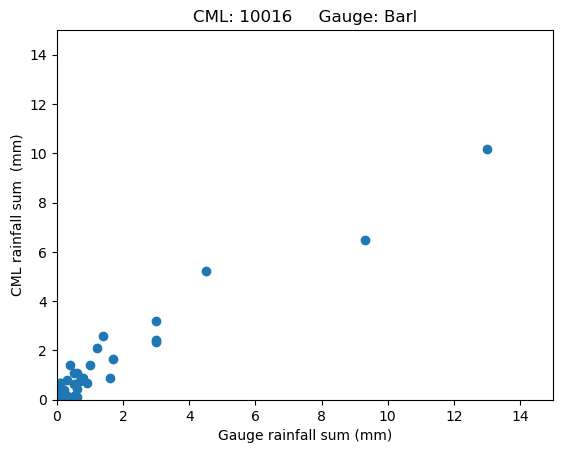

In [32]:
i = 15
cml_id = gauge_id_closest.isel(cml_id=i).cml_id
gauge_id = gauge_id_closest.isel(cml_id=i)

plt.scatter(
    ds_gauges_municp.sel(id=gauge_id).rainfall_amount.resample(time='1h').sum(),
    ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean(),
)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title(f'CML: {cml_id.data}     Gauge: {gauge_id.data}')
plt.xlabel('Gauge rainfall sum (mm)')
plt.ylabel('CML rainfall sum  (mm)');

## Validation metrics and plots

In [33]:
radar_along_cml_R_1h = radar_along_cml.resample(time='1h').mean().transpose()
R_cml_1h = ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean()

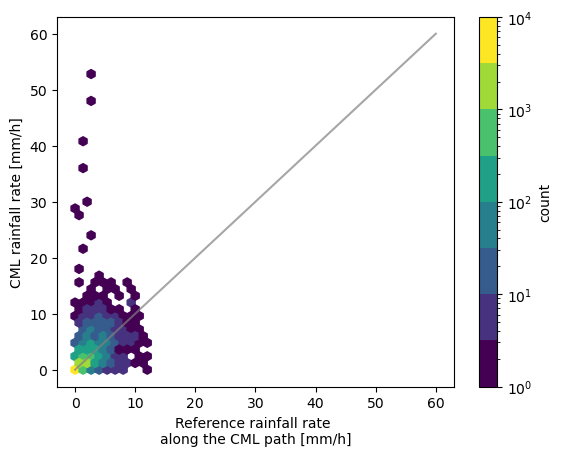

In [34]:
R_threshold = 0.1

plg.validation.plot_hexbin(
    radar_along_cml_R_1h.data.flatten(),
    R_cml_1h.data.flatten(),
    ref_thresh=R_threshold,
    est_thresh=R_threshold,
)

In [35]:
rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
)
rainfall_metrics

{'ref_thresh': 0.1,
 'est_thresh': 0.1,
 'pearson_correlation_coefficient': np.float64(0.572672567388923),
 'coefficient_of_variation': np.float64(1.7830663816582268),
 'root_mean_square_error': np.float64(1.5094172518190991),
 'mean_absolute_error': np.float64(0.6865556669631594),
 'percent_bias': np.float64(20.968563385091464),
 'reference_mean_rainfall': np.float64(0.8407354575574505),
 'estimate_mean_rainfall': np.float64(1.017025604876323),
 'false_positive_mean_rainfall': np.float64(0.31621177411449064),
 'false_negative_mean_rainfall': np.float64(0.36077501473471646),
 'N_all': 69888,
 'N_nan': np.int64(1977),
 'N_nan_ref': np.int64(0),
 'N_nan_est': np.int64(1977)}

(0.09, 10)

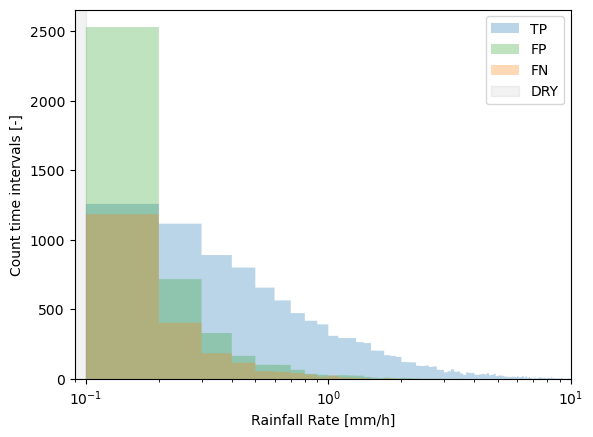

In [36]:
plg.validation.plot_confusion_matrix_count(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=1000,
    bin_type='linear',
);
#plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 10])

(0.09, 10)

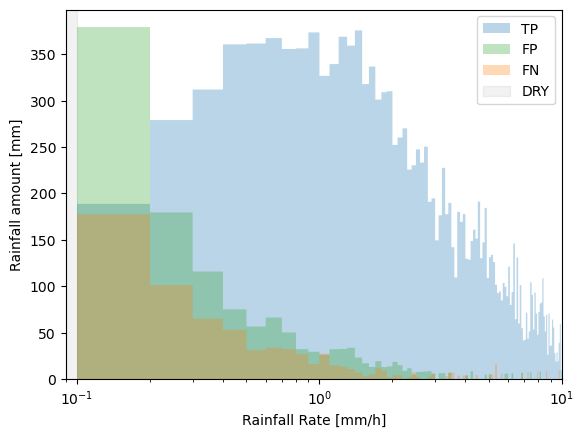

In [37]:
plg.validation.plot_confusion_matrix_sum(
    reference=radar_along_cml_R_1h.data.flatten(),
    estimate=R_cml_1h.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=1000,
    bin_type='linear',
    time_interval=60,
);
#plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 10])

## Other example datasets

### OpenRainER

<img src="https://opensenseaction.eu/wp-content/uploads/2024/03/OpenRainER.jpg" alt="drawing" width="600"/>


In [38]:
(
    ds_rad,
    ds_cmls,
    ds_gauges
) = plg.example_data.load_openrainer(data_dir="example_data", subset='8d')

File already exists at example_data/openrainer_cml_8d.nc
Not downloading!
File already exists at example_data/openrainer_radar_8d.nc
Not downloading!
File already exists at example_data/openrainer_gauges_8d.nc
Not downloading!


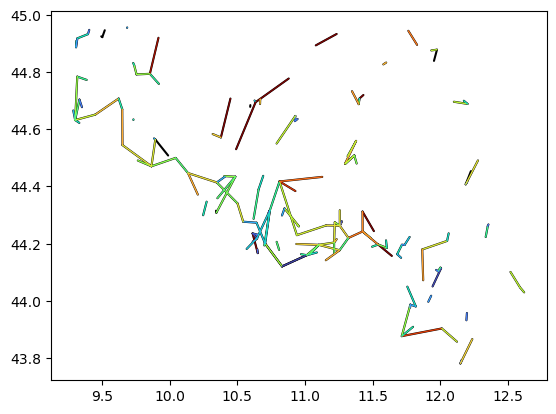

In [39]:
plg.plot_map.plot_lines(ds_cmls.rsl.isel(sublink_id=0).std(dim='time'), vmin=0, vmax=5)

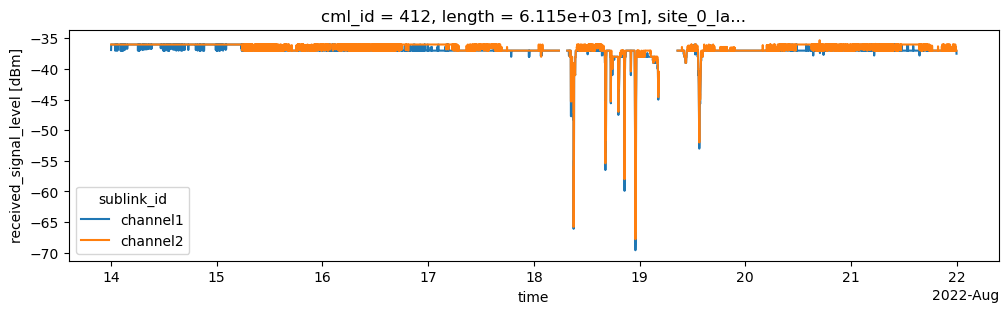

In [40]:
ds_cmls.isel(cml_id=0).rsl.plot.line(x='time', figsize=(12, 3));

### Amsterdam PWS dataset

This is not yet availalbe via `poligrain`. You will use it in the PWS excercises, via a custom download and parsing process.